# Face Verification
Verifying whether a pair of face images belong to the same person irrespective of lighting conditions, age and other nuisance factors.

## Motivation
- Surveillance: Identify a person in one of the footages, now can you automatically find the same person in other footages as well? The footages need not be coming from a single camera
- Biometry: Give biometric access to a particular area (e.g. hotel room, academic labs etc) by verifying whether the person is eligible to be given access or not

## A real story
Baidu's face recognition system helps identify the parents of a missing child. Parents upload a picture of his son when he was 4 years old and the missing person uploads his picture when he was 10 years old. Baidu's system recognized the two faces as belonging to the same person and was able to help reunite the son with his parents.

https://www.dailymail.co.uk/news/peoplesdaily/article-4492814/Man-33-finds-parents-help-facial-recognition.html

## How to solve the face verification problem

Solving face verification robustly requires us to extract features from face images which are invariant to several factors such as age, illumination in the image, face profiles (side/frontal), image resolution etc. However, defining such a feature is a task which seems almost impossible. 

What if we could let the "machine learn" a feature which is invariant to all these factors? However, for this we need a dataset which contains all these different factors. Hence, dataset collection is the most important factor here, as in any other machine learning task.

In [1]:
import numpy as np
import scipy.misc
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import scipy.misc
import os
import warnings
warnings.filterwarnings("ignore")

## Step1: Collect dataset
Here, we are using Yale Faces dataset.

Characteristics of the Yale Faces dataset
- Frontal faces
- Faces captured under various lighting conditions
- Single face per image with a plain background
- Each face has displays various emotions

Link to a webpage containing references to other face datasets:

http://www.face-rec.org/databases/

## Read a few face images from the dataset and display

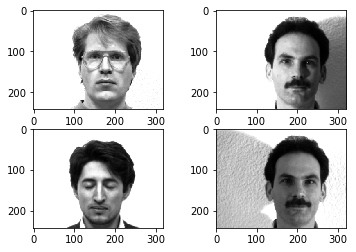

In [2]:
I1 = scipy.misc.imread('yalefaces/subject01.glasses')
I2 = scipy.misc.imread('yalefaces/subject02.leftlight')
I3 = scipy.misc.imread('yalefaces/subject03.sleepy')
I4 = scipy.misc.imread('yalefaces/subject02.rightlight')

plt.subplot(221)
plt.imshow(I1,cmap='Greys_r')

plt.subplot(222)
plt.imshow(I2,cmap='Greys_r')

plt.subplot(223)
plt.imshow(I3,cmap='Greys_r')

plt.subplot(224)
plt.imshow(I4,cmap='Greys_r')

plt.show()

## Step 2: Dataset preprocessing

Idea is to keep only that information in the image which helps in face verification, removing all the unnecessary information (usually called nuisance parameters). Lighting condition is one example of nuisance parameter. Can you list two others? The nuisance parameters need not be in this dataset, but you could encounter in a real-world scenario.

<br>
<br>

<br>
<br>
<br>

<br>
<br>

<br>
<br>

<br>
<br>


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>











## Localize faces in the image and crop
A technical way of saying - "get rid of the background"

Found 4 faces!


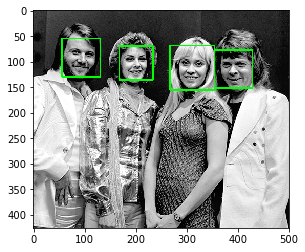

In [3]:
# Here, we use a builtin opencv function to 
#localize the faces in an image and draw a bounding box
# An example code is shown here on an example image 'abba.png'
I = scipy.misc.imread('abba.png')
cascPath = "haarcascade_frontalface_default.xml"

# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)

faces = faceCascade.detectMultiScale(
    I,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
    #flags = cv2.CV_HAAR_SCALE_IMAGE
)

print("Found {0} faces!".format(len(faces)))

# Draw a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(I, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(I,cmap='Greys_r')
plt.show()

## Read the dataset

Read each of the images from the dataset and also crop the face from the data

In [4]:
## read the dataset
full_face = []
full_labels = []
all_images = os.listdir('yalefaces')
for j in range(1,11):    # there are 15 different people in the dataset
    img_list = [filename for filename in all_images if filename.startswith('subject%.2d'%j)]
#     img_list = glob.glob('yalefaces/subject%.2d*'%j)
    face1 = np.zeros((len(img_list),80,60))
    for k,img in enumerate(img_list):
        I = scipy.misc.imread(os.path.join('yalefaces',img))
        faces = faceCascade.detectMultiScale(
            I,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30))
        x,y,h,w = faces[0]
        face1[k,...] = zoom(I[y:y+h,x:x+w],[80./h,60./w])
    labels = (j-1)*np.ones((11,))
    full_face.append(face1)
    full_labels.append(labels)
full_face = np.stack(full_face)    # contains the images of all faces
full_labels = np.stack(full_labels)   # contains the ID of all the faces

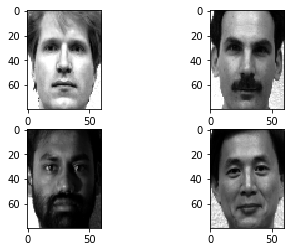

In [5]:
## visualize few faces from the dataset
I1 = full_face[0,5,...]
I2 = full_face[1,4,...]
I3 = full_face[6,3,...]
I4 = full_face[5,7,...]
plt.subplot(221)
plt.imshow(I1,cmap='Greys_r')

plt.subplot(222)
plt.imshow(I2,cmap='Greys_r')

plt.subplot(223)
plt.imshow(I3,cmap='Greys_r')

plt.subplot(224)
plt.imshow(I4,cmap='Greys_r')

plt.show()

In [6]:
print(full_face.shape)
print(full_labels.shape)

(10, 11, 80, 60)
(10, 11)


### Split the data into train and test set

In [7]:
# divide the data into train and test
# pick 2 images from each dataset and put it into test set
train_set = np.zeros((full_face.shape[0],9,80,60))
test_set = np.zeros((full_face.shape[0],2,80,60))
train_labels = np.zeros((full_face.shape[0],9))
test_labels = np.zeros((full_face.shape[0],2))
for k in range(full_face.shape[0]):
    g = np.random.permutation(11)   # randomly select the 9 faces
    train_set[k,...] = full_face[k,g[:9],...]
    train_labels[k,...] = full_labels[k,g[:9]]
    test_set = full_face[:,g[9:],...]
    test_labels[k,...] = full_labels[k,g[9:]]

# Step 3: Feature extraction

Note: A possible step before this would be to include additional pre-processing steps which can get rid of some of the nuisance paramters like lighting conditions

### Question: Why feature extraction?

<br>
<br>
<br>
<br>

<br>
<br>


### List some features you could extract from the images
Keep in mind that these image belong to a specific category which is face and not any arbitrary image

#### Face specific features: Need to be learned from a dataset of faces
- Eigen faces
- Fisher faces
#### General features
- Histogram of Oriented Gradients (HOG)
- Local Binary Pattern Histogram (LBPH)

#### References:
- Face recognition using Eigenfaces: http://www.cin.ufpe.br/~rps/Artigos/Face%20Recognition%20Using%20Eigenfaces.pdf
- Face recognition using Fisherfaces: http://www.dtic.mil/dtic/tr/fulltext/u2/1015508.pdf
- LBPH: https://ieeexplore.ieee.org/document/1717463



Here, we will explore a non-data driven feature which is local binary pattern

![](LBP.png "")

In [8]:
from skimage.feature import local_binary_pattern
train_set = np.reshape(train_set,[-1,80,60])
train_labels = np.reshape(train_labels,[-1,])
test_set = np.reshape(test_set,[-1,80,60])
test_labels = np.reshape(test_labels,[-1,])
train_feat = np.zeros_like(train_set)
test_feat = np.zeros_like(test_set)

for k in range(train_feat.shape[0]):
        train_feat[k,...] = local_binary_pattern(train_set[k,...],8,3)#,method='uniform')
for k in range(test_feat.shape[0]):
        test_feat[k,...] = local_binary_pattern(test_set[k,...],8,3)#,method='uniform')
print(np.amax(test_feat))

255.0


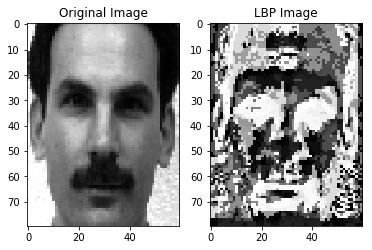

In [9]:
## visualize an original image and an LBP image
idx= 16
plt.subplot(121)
plt.title('Original Image')
plt.imshow(train_set[idx,...],cmap='Greys_r')

plt.subplot(122)
plt.title('LBP Image')
plt.imshow(train_feat[idx,...],cmap='Greys_r')
plt.show()

## Extract features from the LBP image

![](LBPH.png '')

In [10]:
# set the number of grids in x and y direction
# divide the image into the specified number of grids
# for each grid compute the histogram with 64 bins
# concatenate the histogram from all grid regions to form a single feature
# now we have one feature vector per image
# Note that grid size and histogram bin sizes are variable
x_grid = 7
y_grid = 7
grid_size_x = train_feat.shape[1]//x_grid
grid_size_y = train_feat.shape[2]//y_grid
for k in range(train_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = train_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=64)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        data_hist = patch_hist_list[np.newaxis,...]
    else:
        data_hist = np.concatenate([data_hist,patch_hist_list[np.newaxis,...]],0)
print(data_hist.shape)

grid_size_x = test_feat.shape[1]//x_grid
grid_size_y = test_feat.shape[2]//y_grid

for k in range(test_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = test_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=64)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        test_data_hist = patch_hist_list[np.newaxis,...]
    else:
        test_data_hist = np.concatenate([test_data_hist,patch_hist_list[np.newaxis,...]],0)
print(test_data_hist.shape)

(90, 3136)
(20, 3136)


### Perform dimensionality reduction on the feature vector

Number of training samples is way less than the dimensionality of the data, hence reduce the number of data dimensions

In [11]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
train_feat = data_hist
test_feat = test_data_hist
print(train_feat.shape,test_feat.shape)
pca.fit(train_feat)

(90, 3136) (20, 3136)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [12]:
# select number of components which explain 99% of the data variance
n_components = np.argmin(np.cumsum(pca.explained_variance_ratio_)<=0.99)
print(n_components)
train_feat_pca = pca.transform(train_feat)
train_feat_pca = train_feat_pca[:,:n_components]
test_feat_pca = pca.transform(test_feat)
test_feat_pca = test_feat_pca[:,:n_components]
print(train_feat_pca.shape)

82
(90, 82)


### Make pairs of images with labels as positive pair and negative pairs

Positive pairs: Face images of the same person

Negative pairs: Face images of different persons

In [13]:
import itertools
img_pair = []
img_full_pair = []
label_pair = []
for pair in itertools.combinations_with_replacement(range(train_feat_pca.shape[0]),2):
    img_pair.append(train_feat_pca[pair,:])
    img_full_pair.append(train_set[pair,:])
    label_pair.append(train_labels[pair,])
img_pair = np.stack(img_pair)
img_full_pair = np.stack(img_full_pair)
label_pair = np.stack(label_pair)
label_pair = (label_pair[:,0] == label_pair[:,1])
label_pair = label_pair*1

#### Visualize a positive pair of faces

positive pair with label:  1


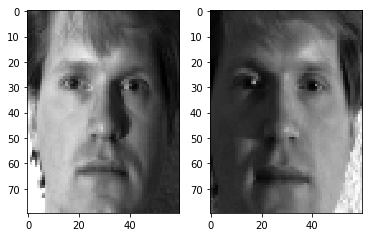

In [14]:
idx=1
img_pair_true = img_full_pair[idx,:]
print('positive pair with label: ',label_pair[idx])
plt.subplot(121)
plt.imshow(img_pair_true[0,...].reshape(80,60),cmap='Greys_r')
plt.subplot(122)
plt.imshow(img_pair_true[1,...].reshape(80,60),cmap='Greys_r')
plt.show()

#### Visualize a negative pair of faces

negative pair with label:  0


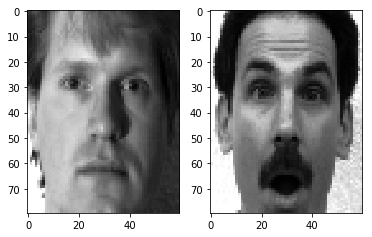

In [15]:
idx=15
img_pair_true = img_full_pair[idx,:]
print('negative pair with label: ',label_pair[idx])
plt.subplot(121)
plt.imshow(img_pair_true[0,...].reshape(80,60),cmap='Greys_r')
plt.subplot(122)
plt.imshow(img_pair_true[1,...].reshape(80,60),cmap='Greys_r')
plt.show()

### Make pairs out of test images

In [16]:
test_img_pair = []
test_label_pair = []
for pair in itertools.combinations_with_replacement(range(test_feat.shape[0]),2):
    test_img_pair.append(test_feat_pca[pair,...])
    test_label_pair.append(test_labels[pair,])
test_img_pair = np.stack(test_img_pair)
test_label_pair = np.stack(test_label_pair)
test_label_pair = (test_label_pair[:,0] == test_label_pair[:,1])
test_label_pair = test_label_pair*1

Now, for training, we have a pair of feature vectors obtained from LBPH per label. However, a classifier needs only one feature vector per sample. We can convert two feature vectors into one by concatenation. However, here we just subtract the two feature vectors two form a single feature vector.

In [17]:
img_pair = np.abs(img_pair[:,0,...] - img_pair[:,1,...])
test_img_pair = np.abs(test_img_pair[:,0,...] - test_img_pair[:,1,...])

### Shuffle the training data and train the classifier

In [18]:
# shuffle the training data
g = np.random.permutation(img_pair.shape[0])
img_pair = img_pair[g,:]
label_pair = label_pair[g,]

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(img_pair,label_pair)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Predict the accuracy

In [19]:
print(clf.score(test_img_pair,test_label_pair))

0.9904761904761905


#### Predict the F1 score

In [20]:
pred = clf.predict_proba(test_img_pair)
from sklearn.metrics import f1_score
print(f1_score(clf.predict(test_img_pair),test_label_pair))

0.9655172413793104


## Data imbalance and bias in the classifier

How many positive pairs are present in the training data?

How many negative pairs are present in the training data?

What's the default accuracy of the classifier?

What metric to choose to fairly evaluate the classifier?

References:
- https://stats.stackexchange.com/questions/90779/area-under-the-roc-curve-or-area-under-the-pr-curve-for-imbalanced-data
- https://www.kaggle.com/general/7517#post41179

Number of thresholds evaluated:  11


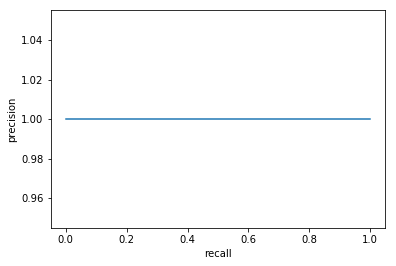

In [21]:
## plot the precision-recall curve

from sklearn.metrics import auc,precision_recall_curve
precision,recall,thr = precision_recall_curve(test_label_pair, pred[:,1], pos_label=1)
print('Number of thresholds evaluated: ',len(thr))
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [22]:
f1_score = (2*precision*recall)/(precision+recall)
print('max f1-score:',np.amax(f1_score))
pr_auc = auc(recall,precision)
print('Area under Precision Recall Curve: ',pr_auc)

max f1-score: 1.0
Area under Precision Recall Curve:  1.0


# The Challenge

- #### Robustness to different nuisance parameters: 
Given a pair of images your trained model should be able to tell whether the faces in the images belong to the same person or not. The test images can be captured under various lighting conditions with various backgrounds. Your trained model should be robust to lighting/illumination changes, image resolution, image aspect ratio, background clutter, morphing of faces (like expressions, wearing glasses etc.) and so on. However, the only thing that can be assured would be that all faces in the test set will be frontal and not side profiles of the faces.
- #### Collecting dataset and cleaning the data:
A very important aspect in making the trained model robust to all the nuisance factors would be to collect dataset with all such nuisance and train your model on such a dataset. Another important step would be to preprocess the images with standard techniques (like image normalization, http://www.idiap.ch/~marcel/labs/faceverif.php) etc. 
- #### Feature selection and feature extraction: 
You are free to extract features of your choice from the given data. The features could be the ones mentioned above or you could find any of your own features. You could use data-dependent features (like PCA or eigenfaces) or data-independent features (like LBPH). You can use only one feature for the classifier or you can use a combination of multiple features as well.
- #### Choice of classifier:
Note that the choice of classifier matters very little to the final score evaluation. What matters most is how diverse a dataset can you collect and how good are the extracted features. However, setting good parameters for the classifier also matters. Hence, search for the best hyperparameters. The only requirement on your classifier is that it should be able to ouput probability scores so as to compute the performance metrics.
- #### Performance Evaluation:
The performance will be evaluated based on two metrics : Max F1-score and the area under the precision recall curve for the test set.
- We will open a Kaggle competition soon where you have to upload your code and trained model. There will be a public test set on which your code should run and there will be a private test set based on which we will evaluate the final score.

## References
- #### List of different face image datasets: 
http://www.face-rec.org/databases/
- #### Some papers on face recognition:
[Face recognition with local binary patterns](https://pdfs.semanticscholar.org/3242/0c65f8ef0c5bd83b14c8ae662cbce73e6781.pdf)

[Face description with local binary patterns: Application to face recognition](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.456.1094&rep=rep1&type=pdf)

[Deepface: Closing the gap to human-level performance in face verification](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Taigman_DeepFace_Closing_the_2014_CVPR_paper.pdf)

[Face recognition using eigenfaces](http://www.cin.ufpe.br/~rps/Artigos/Face%20Recognition%20Using%20Eigenfaces.pdf)

[Kernel eigenfaces vs. kernel fisherfaces: Face recognition using kernel methods](http://faculty.ucmerced.edu/mhyang/papers/fg02.pdf)


#### Image courtesy
- #### LBP images taken from Towards Data Science blog:
https://towardsdatascience.com/face-recognition-how-lbph-works-90ec258c3d6b
- #### Face detection code courtesy:
https://github.com/shantnu/FaceDetect/
